In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
hppc_DIR = "../data/hppc/"
crate_DIR = "../data/crate/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_cycling/"
res_DIR = "../data/results/"

# %matplotlib widget

In [2]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
parameter_values = get_parameter_values()

In [4]:
# parameter_values.search("electrolyte")

In [5]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
print(cell_no)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
cyc_data_raw = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
if int(cell_no)%3 == 1:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
else:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
cyc_data = cyc_data_raw.reset_index(drop=True)
t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
t_c1 = t_c1.values
I_c1 = cyc_data['Current [mA]']/1000
I_c1 = I_c1.values
V_c1 = cyc_data['Voltage [V]']
V_c1 = V_c1.values
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Initial temperature [K]": 273.15+Temp,
        # "Ambient temperature [K]": 273.15+Temp,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
        # "Positive electrode diffusivity [m2.s-1]" NMC_diffusivity,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        # "Upper voltage cut-off [V]": 4.22,
    },
    check_already_exists=False,
)

01


In [6]:
def graphite_diffusivity(sto, T):
  from pybamm import exp, constants
  D_ref = 5.0* 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def NMC_diffusivity(sto, T):
  from pybamm import exp, constants
  D_ref = 8 * 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def electrolyte_diffusivity(c_e, T):
  from pybamm import exp, constants
  D_c_e = 5.35 * 10 ** (-10)
  E_D_e = 0
  arrhenius = exp(E_D_e /constants.R * (1 / 298.15 - 1 / T))
  return D_c_e * arrhenius

def electrolyte_conductivity(c_e, T):
    from pybamm import exp, constants
    sigma_e = 1.3
    E_k_e = 0
    arrhenius = exp(E_k_e / constants.R * (1 / 298.15 - 1 / T))
    return sigma_e * arrhenius

def graphite_electrolyte_exchange_current_density(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 1.061 * 10 ** (-6)  # unit has been converted
  # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0#37480
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )

def NMC_electrolyte_exchange_current_density(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 4.824 * 10 ** (-6)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0 #39570
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )

def NMC_entropic_change(sto, c_s_max):
  return 0
  
def graphite_entropic_change(sto, c_s_max):
  return 0

In [7]:
def graphite_diffusivity1(sto, T):
  from pybamm import exp, constants
  D_ref = 16*5.0* 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def NMC_diffusivity1(sto, T):
  from pybamm import exp, constants
  D_ref = 8 * 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def graphite_electrolyte_exchange_current_density1(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 4*1.061 * 10 ** (-7)  # unit has been converted
  # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0#37480
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )

def NMC_electrolyte_exchange_current_density1(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 4.824 * 10 ** (-7)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0 #39570
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )


In [8]:
parameter_values.update(
    {
      # "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity,
      # "Electrolyte conductivity [S.m-1]": electrolyte_conductivity,
      "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
      # "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity,
      "Negative electrode exchange-current density [A.m-2]": graphite_electrolyte_exchange_current_density,
      # "Positive electrode exchange-current density [A.m-2]": NMC_electrolyte_exchange_current_density,
      # "Negative electrode OCP entropic change [V.K-1]": graphite_entropic_change,
      # "Positive electrode OCP entropic change [V.K-1]": NMC_entropic_change,
      "Negative particle radius [m]": 2.5e-6,
    },
    check_already_exists=False,
)


In [9]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    # ] *40,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [10]:
all_sumvars_dict1 = cycle_adaptive_simulation(spm, parameter_values, experiment,0.99, save_at_cycles=1)

In [11]:
parameter_values.update(
    {
      # "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity1,
      # "Electrolyte conductivity [S.m-1]": electrolyte_conductivity1,
      "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity1,
      # "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity1,
      "Negative electrode exchange-current density [A.m-2]": graphite_electrolyte_exchange_current_density1,
      # "Positive electrode exchange-current density [A.m-2]": NMC_electrolyte_exchange_current_density1,
      # "Negative electrode OCP entropic change [V.K-1]": graphite_entropic_change,
      # "Positive electrode OCP entropic change [V.K-1]": NMC_entropic_change,
      # "Initial temperature [K]": 273.15+25,
      # "Ambient temperature [K]": 273.15+25,
      "Negative particle radius [m]": 10e-6,
      "Positive electrode LAM constant proportional term [s-1]": 1.27152e-07,
      "Negative electrode LAM constant proportional term [s-1]": 1.27272e-06,
      "Positive electrode LAM constant exponential term": 1.1992,
      "Negative electrode LAM constant exponential term": 1.1992,
      "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
      "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
      "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
    },
    check_already_exists=False,
)



In [12]:
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    # ] *60,
    termination="50% capacity",
#     cccv_handling="ode",
)

In [13]:
all_sumvars_dict2 = cycle_adaptive_simulation(spm, parameter_values, experiment,0.99, save_at_cycles=1)

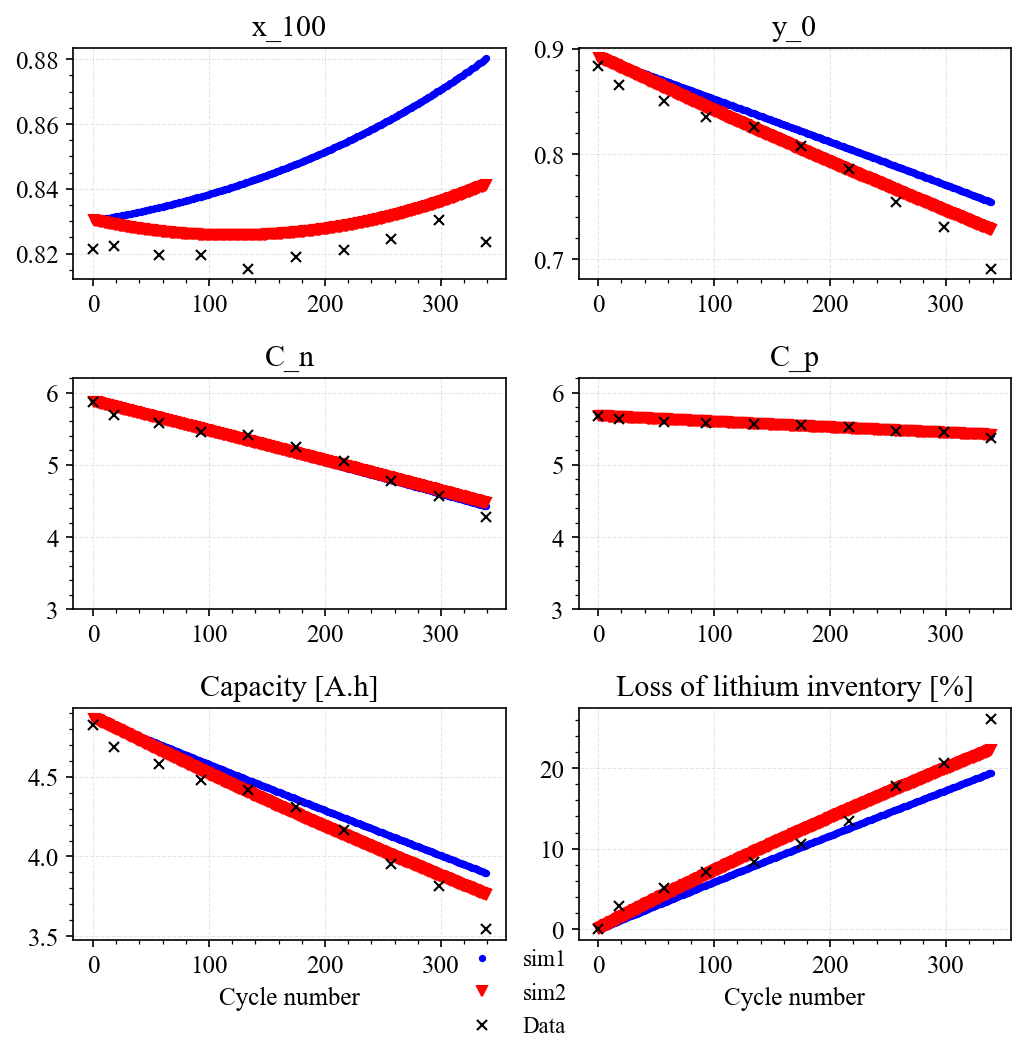

In [14]:
fig = plotc2(all_sumvars_dict1,all_sumvars_dict2,dfe);
# plt.savefig(fig_DIR + 'cell_'+cell_no+f'_graphite_diffusivity_eSOH.png')
# plt.savefig(fig_DIR + 'cell_'+cell_no+f'_nmc_diffusivity_eSOH.png')
# plt.savefig(fig_DIR + 'cell_'+cell_no+f'_graphite_exchange_eSOH.png')
# plt.savefig(fig_DIR + 'cell_'+cell_no+f'_nmc_exchange_eSOH.png')
plt.savefig(fig_DIR + 'cell_'+cell_no+f'_graphite_radius_eSOH_retune.png')